# Training DIPS

**Goal:** Quick study of training DIPS for a few epochs to see a potential workflow the IP based NN algs.

<img src="img/dips_architecture.png" width="600">

In [28]:
import h5py
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import BatchNormalization, Layer, TimeDistributed, Dropout
from keras.layers import Dense, Input, ReLU, Masking, LSTM
from keras.models import Model
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
from plottingFunctions import sigBkgEff

# # Some magic so that the notebook will reload external python modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# functions from umami software for evaluation
import umami.train_tools as utt
from umami.data_tools import LoadTrksFromFile
from umami.preprocessing_tools import apply_scaling_trks, get_variable_dict, binarise_jet_labels

**Step 1:** Load in the data (wich is already preprocessed, achieved using the umami software.)

In [4]:
file_path = "/nfs/dust/atlas/user/pgadow/summie2022/data/vr_dips_samples/hybrid_ttbar_zprime"

In [5]:
trainfile_name = os.path.join(file_path, "VR-hybrid-resampled_scaled_shuffled.h5")
h5f_train = h5py.File(trainfile_name, 'r')

'''
For a first training, just look at part of the data
'''
Ntrain = 200000
X_train = h5f_train['X_tracks_loose_train'][:Ntrain]
y_train = h5f_train['Y_train'][:Ntrain]

h5f_train.close()
print("Number of loaded jets (size of features, size of target labels):", len(X_train), len(y_train))

Number of loaded jets (size of features, size of target labels): 200000 200000


**Step 2:** Set up the architecture

For the most part, [Keras](https://keras.io) is very modular and lets you stack the common layers that you care just like legos to build a custom architecture, and these are the layers that are loaded above.

For the Deep-Sets model, we just needed a custom layer to implement this sum over tracks. 

The only custom layer that we needed was a Sum layer, which is in the block below.

In [6]:
class Sum(Layer):
    """
    Simple sum layer.
    The tricky bits are getting masking to work properly, but given
    that time distributed dense layers _should_ compute masking on their
    own.

    Author: Dan Guest
    https://github.com/dguest/flow-network/blob/master/SumLayer.py

    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.sum(x, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def compute_mask(self, inputs, mask):
        return None


In [7]:
# Store the dimensions of the input dataset for setting up the model
nJets, nTrks, nFeatures = X_train.shape

**Set up the model skeleton** 

The model parameters are set as variables to be easy to train in the tutorial.

- ppm_sizes_int: A list defining the size for each of the dense layers of the per particle network $\Phi$
- dense_sizes_int: A list defining the size for each of the dense layers of the per particle network $F$
- batch_norm: Whether or not to use [BatchNormalization](https://arxiv.org/abs/1502.03167), a regularization technique for deep models. The key idea is that it's easier for models to train if the input are bell shaped and centered around 0 to take advantage of the non-linearity. This is why we normalize the inputs in the pre-processing, and the Batch-Normalization is a technique which normalized the outputs from a network layer so that the next layer has nicely scaled inputs for the training. 
- [dropout](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) (*currently not used*): The rate at which to drop neurons from the previous layer in the next layer during the training. This is another regularization tecnique since during training, you're not going to overly rely on a single neuron for the classification.  If dropout is 0, then the Dropout layer will not be included.

In [8]:
ppm_sizes_int = [100,100,128]
dense_sizes_int = [100,100,100]

batch_norm = True
dropout = 0 # no dropout being used right now
nClasses = 3

In [9]:
trk_inputs = Input(shape=(nTrks,nFeatures))
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

# Define a "Phi" neural network for each track
for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name="Phi{}_Dense".format(i))(tdd)
    if batch_norm:
        tdd = TimeDistributed(BatchNormalization(),name="Phi{}_BatchNormalization".format(i))(tdd)
    if dropout != 0:
        tdd = TimeDistributed(Dropout(rate=dropout),name="Phi{}_Dropout".format(i))(tdd)
    tdd = TimeDistributed(ReLU(),name="Phi{}_ReLU".format(i))(tdd)


# This is where the magic happens... sum up the track features!
F = Sum(name="Sum")(tdd)

# Define a deep neural network "F", which takes the summed output of the "Phi" networks
for j, (F_nodes, p) in enumerate(zip(dense_sizes_int,
                                 [dropout]*len(dense_sizes_int[:-1])+[0])):

    F = Dense(F_nodes, activation='linear', name="F{}_Dense".format(j))(F)
    if batch_norm:
        F = BatchNormalization(name="F{}_BatchNormalization".format(j))(F)
    if dropout != 0:
        F = Dropout(rate=p,name="F{}_Dropout".format(j))(F)
    F = ReLU(name="F{}_ReLU".format(j))(F)

# Final output of the "F" network: the 3 classes (nClasses=3) pb, pc, pu
# use of "softmax" activation function ensures their value to be in range 0 to 1
output = Dense(nClasses, activation='softmax',name="Jet_class")(F)
dips = Model(inputs=trk_inputs, outputs=output)

2022-08-09 13:03:13.750253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-09 13:03:13.750295: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-09 13:03:13.750328: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (batch1359.desy.de): /proc/driver/nvidia/version does not exist
2022-08-09 13:03:13.750560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


As a sanity check, you can check the structure of the model.

In [10]:
dips.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 15)]          0         
                                                                 
 masking (Masking)           (None, 40, 15)            0         
                                                                 
 Phi0_Dense (TimeDistributed  (None, 40, 100)          1600      
 )                                                               
                                                                 
 Phi0_BatchNormalization (Ti  (None, 40, 100)          400       
 meDistributed)                                                  
                                                                 
 Phi0_ReLU (TimeDistributed)  (None, 40, 100)          0         
                                                                 
 Phi1_Dense (TimeDistributed  (None, 40, 100)          10100 

**Step 3:** Train the model

To train the model, you need to define what you mean by a model performing better or worse, which we quantify by a *loss function*. For multi-class classification, we use the categorical [cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/), which maximizes the node corresponding to the true label of the jet.

You also need a strategy for updating the weights as you minimize the loss, which is inside the optimizer. There are many different [optimization strategies](https://keras.io/optimizers/) on the market and available in Keras, but the optimizer adam is often a good one to start with since it provides a way to decrease the weight update as you converge onto a solution.

This is what is done in the "compile" function below.

In [11]:
dips.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['acc'])

Before training... how well does the model do? 

In [12]:
dips.evaluate(X_train,y_train)

6250/6250 [==============================] - 22s 4ms/step - loss: 1.5546 - acc: 0.3327


[1.55455482006073, 0.33266499638557434]

The second number above is the accuracy, which is close to 1/3, since before training the model is just guessing among the three outputs.

The first number is the loss, which gets minimized in the training.


**Training details**

When training a model, how do you decide how long to go for? 

When training NNs, you look at your training dataset multiple times as you converge to a solution. A single pass over the training dataset is called an *epoch*.

The model `nEpochs` is set at 5 right now and is a variable for the *maximimum* number of epochs, but in practice, it's common to set this value to something larger, and use the loss on a separate validation dataset to decide when to stop training. 
This is set up in the `EarlyStopping` callback which says to stop training when the loss on the validation dataset (val_loss) has not improved in 10 epochs, when trying out larger values for `nEpochs`.

Then the ModelCheckpoint below saves the name for the model weights file you're using.

In [13]:
nEpochs = 5

earlyStop = EarlyStopping(monitor='val_loss', verbose=True, patience=10)

dips_mChkPt = ModelCheckpoint('dips_weights.h5',monitor='val_loss', verbose=True,
                              save_best_only=True,
                              save_weights_only=True)

Now we'll improve on this by training on this extended hybrid sample.

In [14]:
dips_hist = dips.fit(X_train, y_train, epochs=nEpochs, batch_size=256,validation_split=0.2,
                     callbacks=[earlyStop, dips_mChkPt])

Epoch 1/5
625/625 [==============================] - ETA: 0s - loss: 0.7777 - acc: 0.6324
Epoch 1: val_loss improved from inf to 0.74126, saving model to dips_weights.h5
625/625 [==============================] - 22s 33ms/step - loss: 0.7777 - acc: 0.6324 - val_loss: 0.7413 - val_acc: 0.6498
Epoch 2/5
624/625 [============================>.] - ETA: 0s - loss: 0.7370 - acc: 0.6557
Epoch 2: val_loss improved from 0.74126 to 0.73171, saving model to dips_weights.h5
625/625 [==============================] - 20s 32ms/step - loss: 0.7369 - acc: 0.6557 - val_loss: 0.7317 - val_acc: 0.6566
Epoch 3/5
624/625 [============================>.] - ETA: 0s - loss: 0.7278 - acc: 0.6592
Epoch 3: val_loss improved from 0.73171 to 0.73071, saving model to dips_weights.h5
625/625 [==============================] - 21s 34ms/step - loss: 0.7277 - acc: 0.6592 - val_loss: 0.7307 - val_acc: 0.6608
Epoch 4/5
625/625 [==============================] - ETA: 0s - loss: 0.7221 - acc: 0.6638
Epoch 4: val_loss impro

The information is printed out above, but we can visulalize the evolution loss and accuracy during training by the loss and accuracy. You can see that during training, the loss is going down while the accuracy is going up. Since the training loss is clearly going down while the validation loss has continued to improve with longer training, we're overfitting to the training dataset because the validation training dataset has stopped to improve.

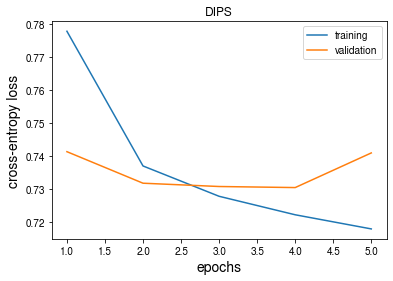

In [39]:
epochs = np.arange(1,len(dips_hist.history['loss'])+1)

plt.plot(epochs,dips_hist.history['loss'],label='training')
plt.plot(epochs,dips_hist.history['val_loss'],label='validation')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()
plt.title('DIPS')

plt.show()

If you are training with more epochs than just 5, you will notice that the validation loss is not improving even though the training loss is. Since we're training with only 200k jets, we're overfitting right now.
Using a larger set of training data could remedy this issue.

## Training convergence as function of epochs

A first evaluation of the model is performed with just 5 epochs. What happens to the training loss and the validation loss when increasing `nEpochs` to a larger value, e.g. 10, or 20?

What happens if you increase the number of jets by from 200000 to twice the amount, i.e. 400000?

## Evaluation of performance using a test dataset

The performance of the trained network must be evaluated using a separate dataset.

We will evaluate the performance of the training using the hybrid sample on a ttbar dataset.
However, some preparation of the test data is required, such that the mathematical function defined by the Dips neural network can be evaluated.

Remember, that the training dataset has undergone preprocessing and has a few input features scaled and shifted.
Consequentially, also these features in the test dataset need to be scaled with the values used for scaling the training dataset.

The test sample for ttbar and graviton are provided here:

- ttbar: `/nfs/dust/atlas/user/pgadow/summie2022/data/vr_dips_samples/hybrid_ttbar_zprime/prepared_samples/inclusive_testing_ttbar_TrackJets.h5`
- Z': `/nfs/dust/atlas/user/pgadow/summie2022/data/vr_dips_samples/hybrid_ttbar_zprime/prepared_samples/inclusive_testing_zprime_TrackJets.h5`

In the following, we will load the ttbar sample.

In [40]:
# Load the test dataset using a helper function from the umami software
test_file_name = os.path.join(file_path, "prepared_samples/inclusive_testing_ttbar_TrackJets.h5")
n_jets = 10_000
class_labels = ["ujets", "cjets", "bjets"]
cut_vars_dict = None
tracks_name = "tracks_loose"

trks, labels = LoadTrksFromFile(
    filepath=test_file_name,
    class_labels=class_labels,
    n_jets=n_jets,
    tracks_name=tracks_name,
    cut_vars_dict=cut_vars_dict,
)

# Convert the jet truth labels using another helper function from the umami software
y_test = binarise_jet_labels(
    labels=labels,
    internal_labels=list(range(len(class_labels))),
)

INFO:umami: Loaded 10000 jets!


In [41]:
# Load variables used in Dips training
var_dict = os.path.join(file_path, "configs/Dips_Variables_R22.yaml")
variable_config = get_variable_dict(var_dict)

# Load scale dict from preprocessing of training sample
scale_dict_path = os.path.join(file_path, "scale_dicts/VR-scale_dict.json")
with open(scale_dict_path, "r") as infile:
    scale_dict = json.load(infile)["tracks_loose"]

In [42]:
# Apply scaling to the tracks
X_test, _ = apply_scaling_trks(
    trks=trks,
    variable_config=variable_config,
    scale_dict=scale_dict,
    tracks_name=tracks_name,
)

Now that we have loaded the test dataset, we can plot the discriminant distribution

$$
D_b = \ln \left(\frac{p_u}{f_c \cdot p_c + (1 - f_c) \cdot p_u}\right)
$$

for the three different jet flavours (light-flavour jets, c-jets, and b-jets).

We then will construct a ROC curve "by hand" (compared to plotting it using puma, as was the case earlier).

313/313 [==============================] - 1s 4ms/step


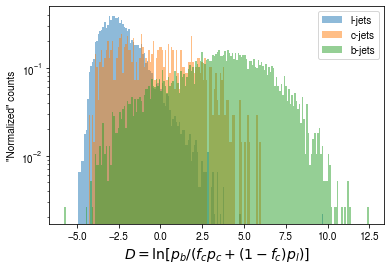

In [44]:
# Compute light-jet, c-jet, b-jet efficiency and plot discriminant score distribution
(leff, ceff, beff), d = sigBkgEff(dips, X_test, y_test, returnDisc=True)

/tmp/ipykernel_58855/3026308212.py:5: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(beff, 1 / leff, color='C4', label='dips: l-rej')
/tmp/ipykernel_58855/3026308212.py:8: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(beff, 1 / ceff, color='C4', linestyle='--', label='dips: c-rej')


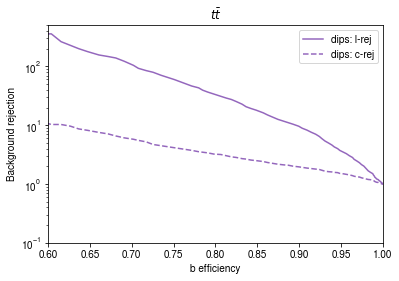

In [45]:
# ROC curve: 

# l-rej
fig, ax = plt.subplots()
ax.plot(beff, 1 / leff, color='C4', label='dips: l-rej')

# c-rej
ax.plot(beff, 1 / ceff, color='C4', linestyle='--', label='dips: c-rej')
plt.xlabel('b efficiency')
plt.ylabel('Background rejection')

plt.legend()
plt.title(r'$t\bar{t}$')
plt.yscale("log")
plt.xlim(0.6, 1)
plt.ylim(0.1, 500)

plt.show()

## First hyperparameters to tune

- number of layers
- size of the layers

- batch normalization
- dropout

*And many more...*

[Tips and tricks for hyperparameter optimization](http://cs231n.github.io/neural-networks-3/)
